In [2]:
import sys
import yt.units as u
import numpy
import numpy as np
import matplotlib.pyplot as plt
import pyximport

from dengo.chemical_network import \
    ChemicalNetwork, \
    reaction_registry, \
    cooling_registry, species_registry
import dengo.primordial_rates, dengo.primordial_cooling
from dengo.chemistry_constants import tiny, kboltz, mh
import h5py
import os
import numpy
import h5py

os.environ['HDF5_DIR'] = '/home/kwoksun2/anaconda2/'

/home/kwoksun2/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


 using cli
 using CLI for selections


In [3]:
Tdim = 16
Ddim = 16

temp_list = numpy.logspace(2,3.7,Tdim)
den_list  = numpy.logspace(0,14,Ddim)

temp_2d, den_2d = numpy.meshgrid(temp_list,den_list)
den_temp_pair2d = numpy.dstack( (temp_2d,den_2d)  )

den_temp_pair2d = ( numpy.reshape(den_temp_pair2d, (Tdim*Ddim,2) )  )

In [4]:
def Init_values(temperature, density, n_species = 9, cooling=True, size=10):
    """ Create a initial value dictionary,
        for a given temperature, density, number of species
    Args:
        temperature -- in Kelvin
        density     -- in amu / cm**3
        n_species   -- number of species (6/9)
        cooling

    Returns:
        init_values: initial value dictionary with
                     self-consistent energy/ electron density
        primordial : chemical_network classes

    """

    # initialize and setup the network
    dengo.primordial_rates.setup_primordial()
    primordial = ChemicalNetwork()
    primordial.threebody = 4

    if n_species == 9:
        for i in range(22):
            try:
                primordial.add_reaction("k{0:02d}".format(i+1))
            except:
                pass
    else:
        for i in range(6):
            try:
                primordial.add_reaction("k{0:02d}".format(i+1))
            except:
                pass

    # the temperature array required to interpolates the rates
    primordial.init_temperature((1e0, 1e5))

    tiny = 1.0e-20

    # init_array are is in fractional abundances
    init_values = dict()
    density = numpy.array([density])*numpy.ones((size))
    if n_species == 6:
        # 6-species model
        init_values["He_1"]    = density * (1.0 - 0.76)
        init_values["He_2"]    = np.array([tiny])
        init_values["He_3"]    = np.array([tiny])
        init_values["H_1"]     = density *  (0.76)
        init_values['H_2']     = np.array([tiny]) 
    else:
        # 9-species model
        init_values["He_1"]    = density * (1.0 - 0.76) 
        init_values["He_2"]    = density *np.array([tiny])
        init_values["He_3"]    = density *np.array([tiny])
        init_values["H_1"]     = density *  (0.76)
        init_values['H_2']     = density *np.array([tiny])

        init_values["H_m0"]    = density *np.array([tiny])
        init_values["H2_1"]    = density *np.array([tiny])
        init_values["H2_2"]    = density *np.array([tiny])

    # now everything in mass density
    init_values['de'] = primordial.calculate_free_electrons(init_values)
    # one signle value: again mass density
    init_values['density'] = primordial.calculate_total_density(init_values)

    num_den = {}
    for sp in primordial.required_species:
        try:
            num_den[sp.name] = init_values[sp.name]/ sp.weight
        except:
            pass

    # set up initial temperatures values used to define ge
    init_values['T'] = numpy.array([temperature])*numpy.ones((size))
    ge_array = numpy.ones((size))
    init_values['ge'] = ge_array
    
    # calculate gammaH2
    
    for i in range(size):
        
        temperature = init_values['T'][i]
        x = 6100.0/temperature
        expx = numpy.exp(x)
        gammaH2 = 2.0 / (5.0 + 2.0*x*x*expx / (expx - 1 )**2.0 ) + 1

        rs = primordial.required_species
        H2_1_sp = list(rs)[0]
        gammaH2 = primordial.species_gamma(H2_1_sp,name=False, temp=True).subs({'T':temperature})

        new_num_den = {}
        for ele in num_den.keys():
            new_num_den[ele] = num_den[ele][i]
        
        gamma_factor = primordial.gamma_factor().subs(new_num_den).subs({'gammaH2': gammaH2 , 'gamma': 5./3.,'T': temperature })

        ge  = ((temperature *  kboltz) *gamma_factor
                             / (init_values['density'][i] * mh  ))

        
        T = init_values['density']*ge*mh / kboltz / gamma_factor
        init_values['ge'][i] = numpy.float64(ge)
    print(ge)
    if cooling:
        for cooling_action in cooling_registry:
            k = cooling_registry[cooling_action]
            if (k.species).issubset( primordial.required_species ):
                                    
                print("adding cooling: {}".format(k.name) )
                primordial.add_cooling(cooling_action)
    return init_values, primordial

# Generate Initial Conditions & Write the solver

In [5]:
density = 1e14
initial_temperature = 3000.0
final_time = (1.0 / (u.G * u.mass_hydrogen * u.cm**-3 * density)**0.5).in_cgs().v



init, primordial = Init_values(initial_temperature, 
                               density, n_species = 9, 
                               cooling=True,size=1)
primordial.stop_time = final_time


solver_name = "cache"

primordial.write_solver(solver_name, output_dir = "testing_cache/",
    solver_template = "cv/sundials_CVDls",
    ode_solver_source = "initialize_cvode_solver.C",
    init_values=init,
    input_is_number=False)

Adding reaction: k01 : 1*H_1 + 1*de => 1*H_2 + 2*de
Adding reaction: k02 : 1*H_2 + 1*de => 1*H_1
Adding reaction: k03 : 1*He_1 + 1*de => 1*He_2 + 2*de
Adding reaction: k04 : 1*He_2 + 1*de => 1*He_1
Adding reaction: k05 : 1*He_2 + 1*de => 1*He_3 + 2*de
Adding reaction: k06 : 1*He_3 + 1*de => 1*He_2
Adding reaction: k07 : 1*H_1 + 1*de => 1*H_m0
Adding reaction: k08 : 1*H_m0 + 1*H_1 => 1*H2_1 + 1*de
Adding reaction: k09 : 1*H_1 + 1*H_2 => 1*H2_2
Adding reaction: k10 : 1*H2_2 + 1*H_1 => 1*H2_1 + 1*H_2
Adding reaction: k11 : 1*H2_1 + 1*H_2 => 1*H2_2 + 1*H_1
Adding reaction: k12 : 1*H2_1 + 1*de => 2*H_1 + 1*de
Adding reaction: k13 : 1*H2_1 + 1*H_1 => 3*H_1
Adding reaction: k14 : 1*H_m0 + 1*de => 1*H_1 + 2*de
Adding reaction: k15 : 1*H_m0 + 1*H_1 => 2*H_1 + 1*de
Adding reaction: k16 : 1*H_m0 + 1*H_2 => 2*H_1
Adding reaction: k17 : 1*H_m0 + 1*H_2 => 1*H2_2 + 1*de
Adding reaction: k18 : 1*H2_2 + 1*de => 2*H_1
Adding reaction: k19 : 1*H2_2 + 1*H_m0 => 1*H_1 + 1*H2_1
Adding reaction: k21 : 2*H_1 

/home/kwoksun2/dengo/dengo-project-dengo-ed14369817a2/dengo/primordial_cooling.py:326: RuntimeWarning: overflow encountered in power
  + 70.609154 * lt3[_i2] **8)
/home/kwoksun2/dengo/dengo-project-dengo-ed14369817a2/dengo/primordial_cooling.py:350: RuntimeWarning: overflow encountered in power
  + 1.8161874 * lt3**8)


# Import as a python module

In [1]:
import pyximport
pyximport.install(setup_args={"include_dirs":np.get_include()},
                      reload_support=True, inplace=True)

sunny_solver_run = pyximport.load_module("cache_solver_run",
                                "testing_cache/cache_solver_run.pyx",
                                build_inplace = True, pyxbuild_dir = "_dengo_temp")

NameError: name 'np' is not defined

# 

In [139]:
def get_name_from_file( name = "real", filename = 'final/runtest.output' ):
    f = open(filename, 'r')
    result = list()
    for line in f:
        if name in line:
            result.append(line)
    f.close()
    return result

def change_time_to_s( min_s ):
    minutes, seconds =  min_s.strip('s').split('m')
    minute = float(minutes)
    second = float(seconds)
    
    total_time = minute*60.0 + second
    
    return total_time

In [140]:
def make_2dcolorplot( time_taken, title = "runtime", cbar_label = 'log ( dengo runtime / grackle runtime )', vmin = -5, vmax = 0 ):
    fig,ax = plt.subplots(dpi = 200)
    timemap = ax.pcolor(temp_2d, den_2d, numpy.log10( (time_taken )    ) , vmin=vmin, vmax=vmax )
    ax.set_xscale('log')
    ax.set_yscale('log')
    cbar = plt.colorbar(timemap)
    cbar.set_label( cbar_label )
    ax.set_xlabel('Temperature (K)')
    ax.set_ylabel('Density ($cm^{-3}$)')
    ax.set_title(title)
    

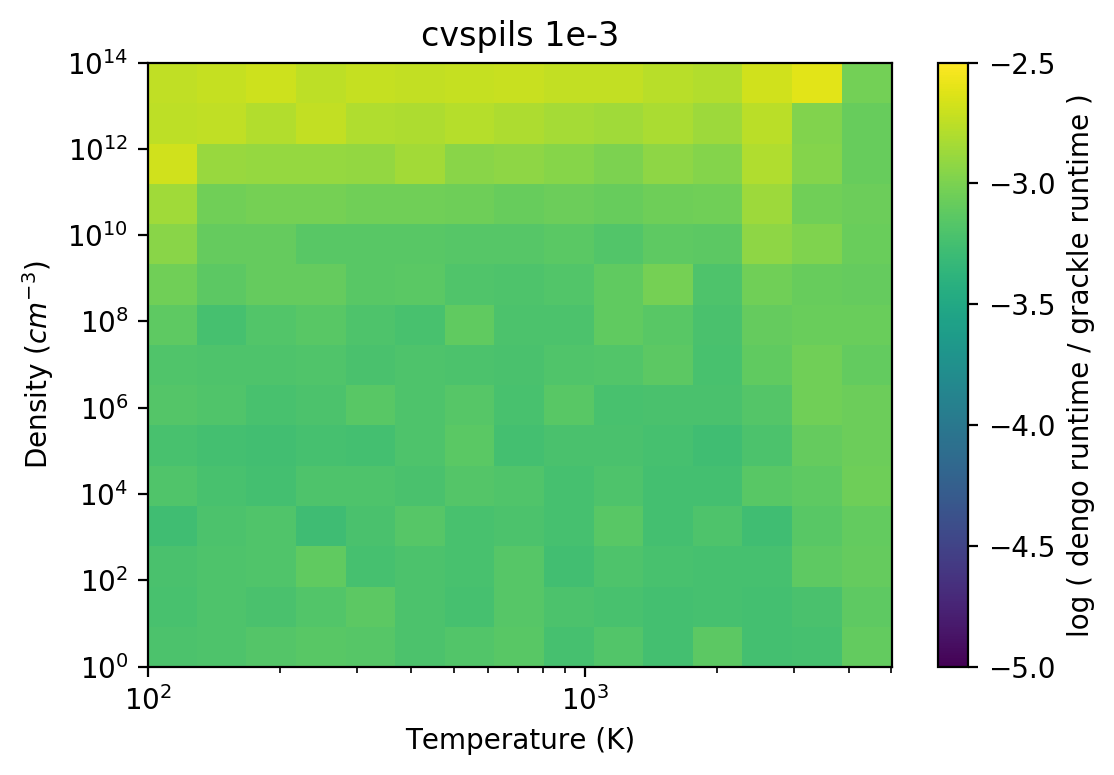

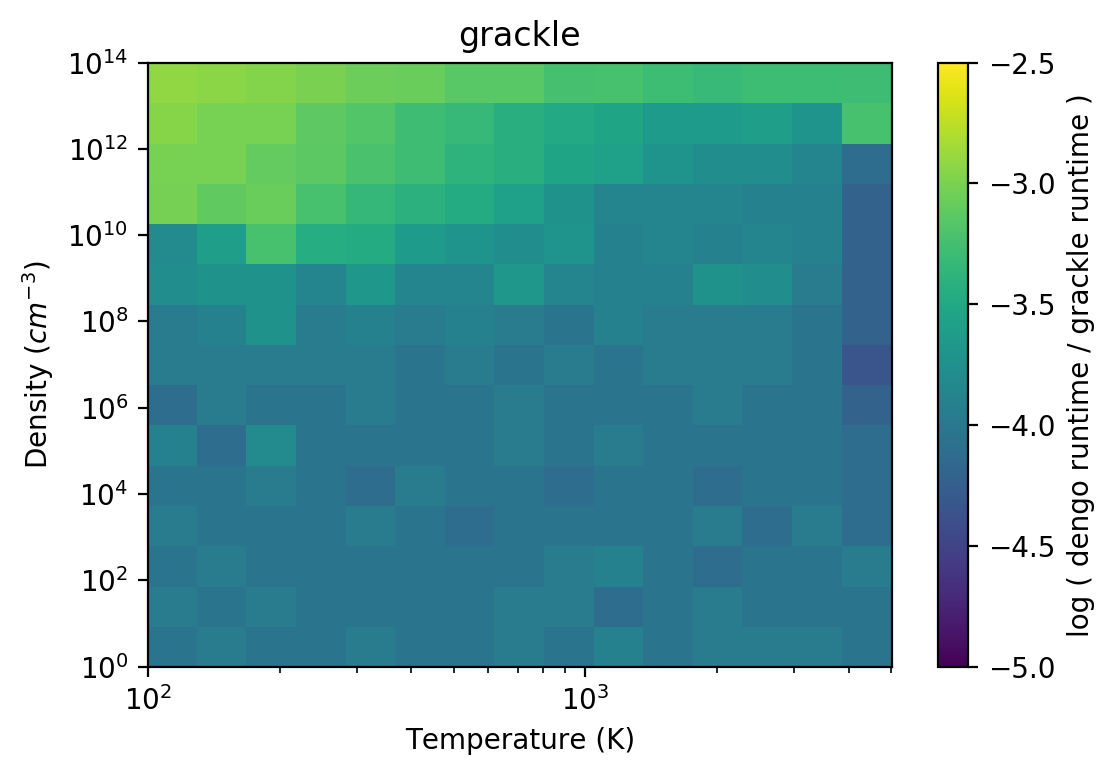

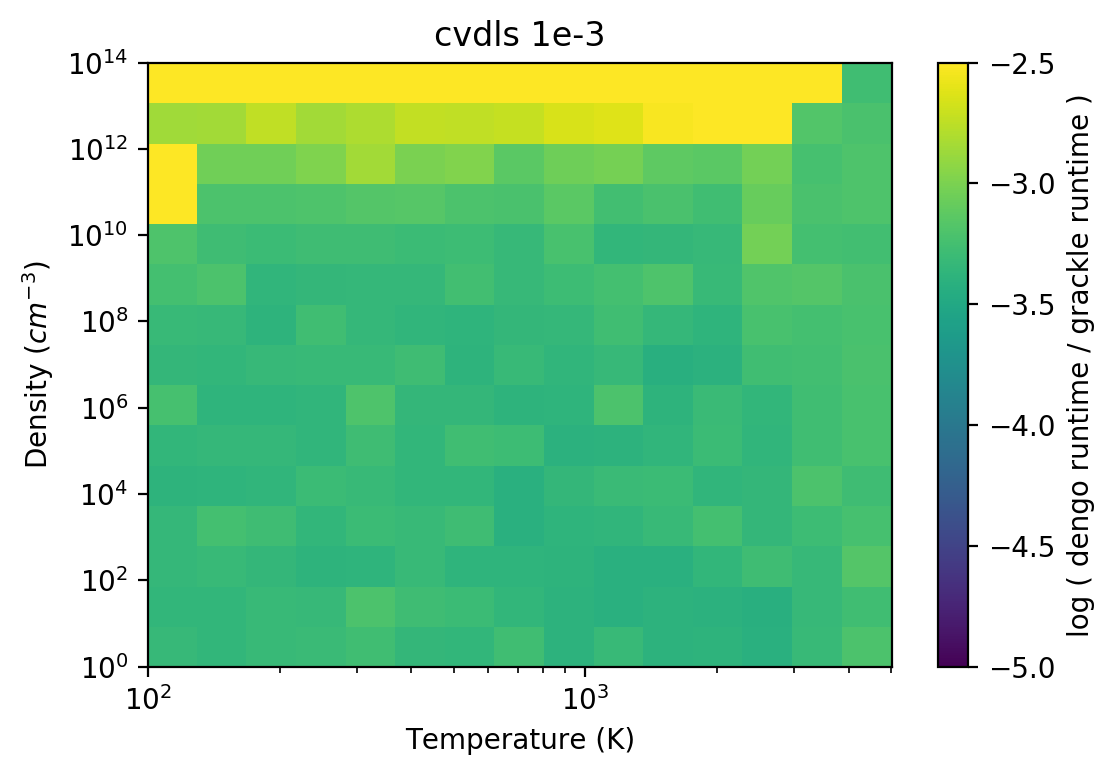

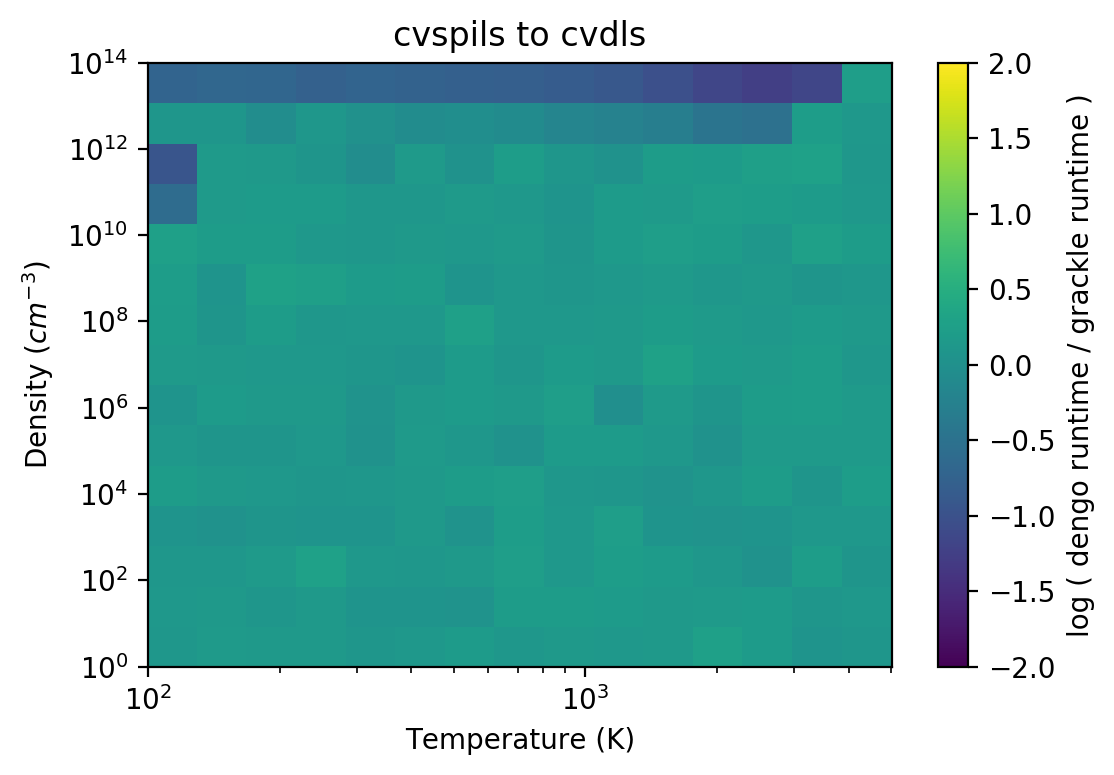

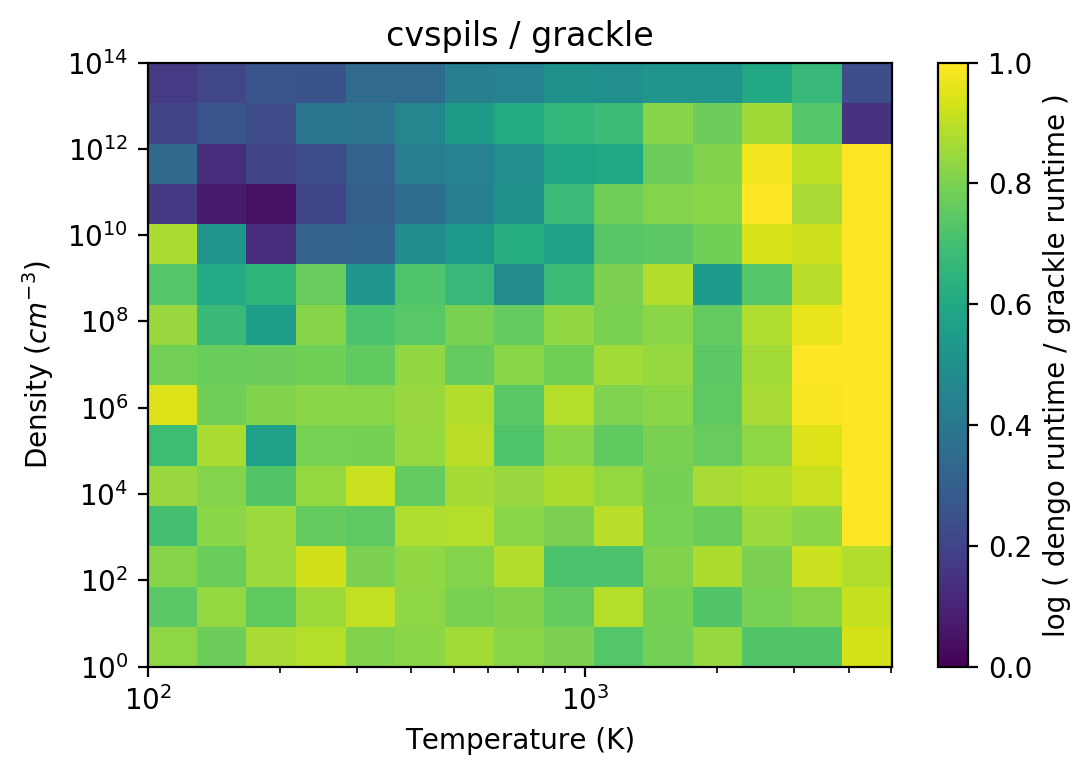

In [141]:
time = get_name_from_file(filename = 'new/run_test_spils.out')
real_time = []
for t in time:
    _time_ = t.strip("\n").split('\t')[1]
    real_time.append( change_time_to_s(_time_) )
    

time_taken_dengo = numpy.array(real_time).reshape((16,16))

grackle_timeout = "/home/kwoksun2/grackle/src/example/grackle_runtime.out"
grackle_2d = numpy.loadtxt(grackle_timeout).reshape((16,16))


old_time = get_name_from_file(filename = "new/run_test_dls.out")
old_real_time = []
for t in old_time:
    _time_ = t.strip("\n").split('\t')[1]
    
    old_real_time.append( change_time_to_s(_time_) )

old_time_taken_dengo = numpy.array(old_real_time).reshape((16,16))


# plt.title('cvspils 1e-3 ')
# plt.imshow( numpy.log10(time_taken_dengo / 1024) ,origin='lower')
# plt.clim(-4, -2.5)
# plt.colorbar()
# plt.show()

make_2dcolorplot( time_taken_dengo/1024.0 ,  title = "cvspils 1e-3", vmin=-5, vmax=-2.5 )

# plt.title('grackle ')
# plt.imshow( numpy.log10(grackle_2d / 1024) ,origin='lower')
# plt.clim(-4, -2.5)
# plt.colorbar()
# plt.show()

make_2dcolorplot( grackle_2d/1024.0 ,  title = "grackle", vmin=-5, vmax=-2.5 )


make_2dcolorplot( old_time_taken_dengo/1024.0 ,  title = "cvdls 1e-3", vmin=-5, vmax=-2.5 )

# plt.title('cvdls 1e-3')
# plt.imshow( numpy.log10(old_time_taken_dengo / 1024) ,origin='lower')
# plt.clim(-4, -2.5)
# plt.colorbar()
# plt.show()


# plt.title('cvspils to cvdls')
# plt.imshow( numpy.log10(time_taken_dengo / old_time_taken_dengo) ,origin='lower', vmin=-2.0, vmax=2.0, cmap=plt.get_cmap('bwr'))
# plt.colorbar()
# plt.show()

make_2dcolorplot( time_taken_dengo / old_time_taken_dengo ,  title = "cvspils to cvdls", vmin=-2, vmax=2 )

# plt.title('cvspils / grackle')
# plt.imshow( numpy.log10(time_taken_dengo / grackle_2d) ,origin='lower')
# plt.colorbar()
# plt.show()

make_2dcolorplot( time_taken_dengo / grackle_2d ,  title = "cvspils / grackle", vmin=0, vmax=1 )

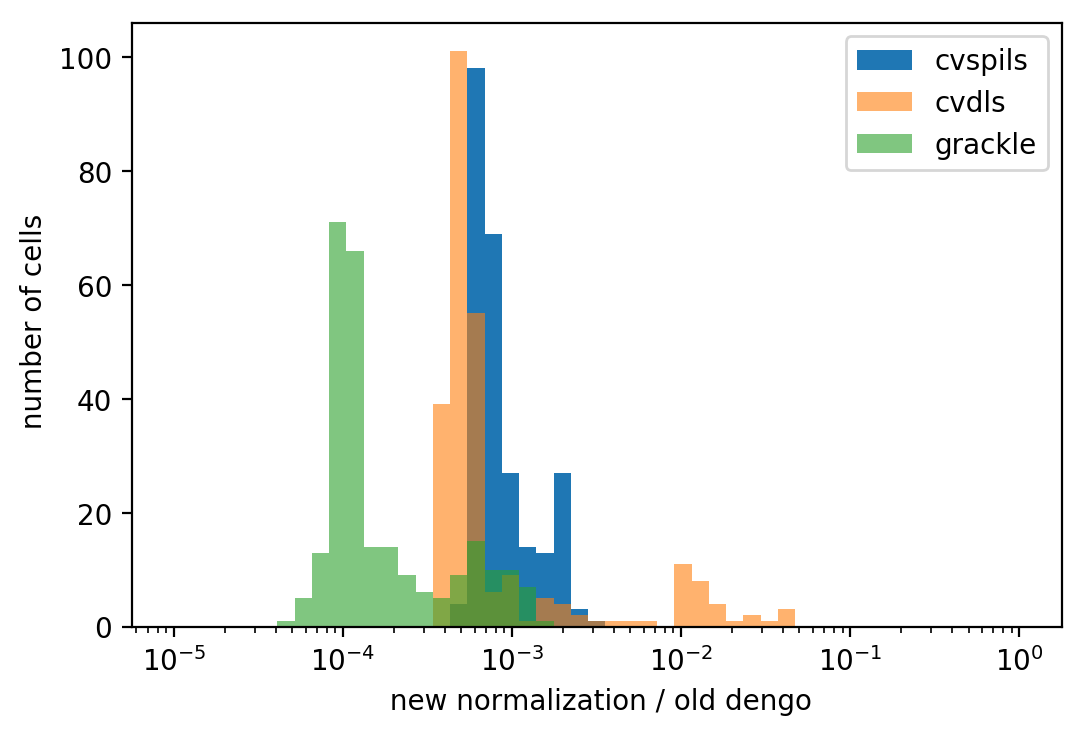

In [152]:
plt.figure(dpi=200)
plt.hist( (time_taken_dengo / 1024 ).flatten()  , bins=np.logspace( -5, 0, 50) ,label='cvspils')

plt.hist( (old_time_taken_dengo / 1024 ).flatten()  , bins=np.logspace( -5, 0, 50), alpha=0.6,label='cvdls' )


plt.gca().set_xscale('log')
plt.xlabel(' new normalization / old dengo')
plt.ylabel(' number of cells')


plt.hist( ( grackle_2d / 1024  ).flatten()  , bins=np.logspace(-5, 0, 50), alpha=0.6 ,label='grackle')
plt.legend()
plt.show()

/home/kwoksun2/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.


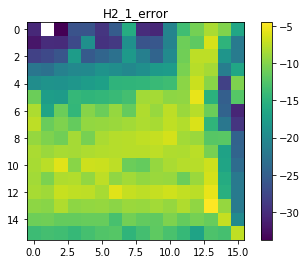

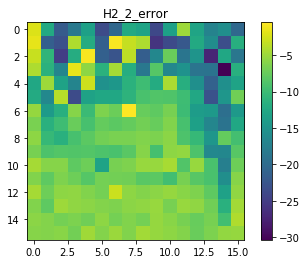

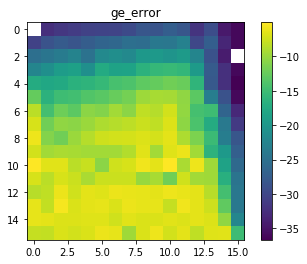

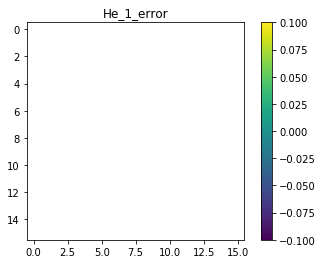

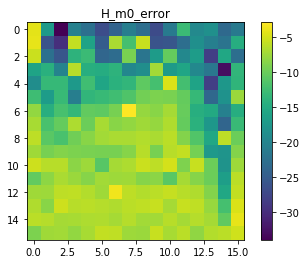

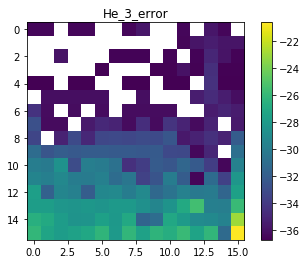

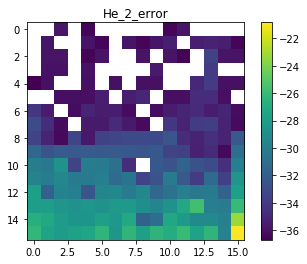

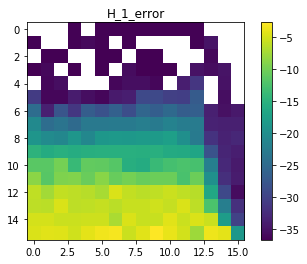

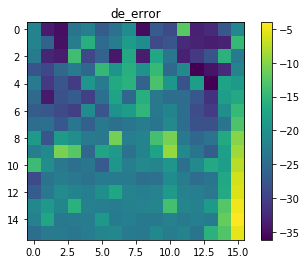

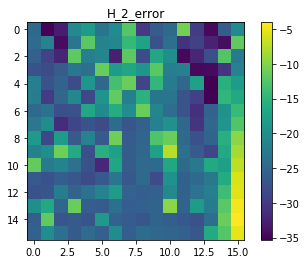

In [31]:
for element in primordial.required_species:
    ele = element.name
    sp = get_name_from_file(name='{}_error'.format( ele ),filename = 'new/run_test_spils.out')
    sp_list = []
    for s in sp:
        flag = s.strip('\n').split(':')[1]
        sp_list.append( float(flag) )

    plt.title('{}_error'.format(ele) )
    
    im_array = numpy.array(sp_list).reshape((16,16) )
        
    
    
    plt.colorbar()
    plt.show()

/home/kwoksun2/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


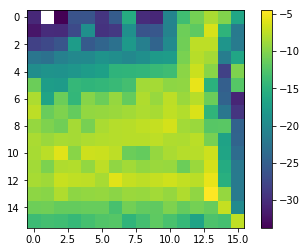

In [100]:
t = (u.mass_hydrogen * u.G * u.cm**-3 * 1e14)**(-0.5)

In [103]:
t / 1e8

2.992049173271223 s

In [22]:
density = 1e14
initial_temperature = 3000.0
final_time = (1.0 / (u.G * u.mass_hydrogen * u.cm**-3 * density)**0.5).in_cgs().v



init, primordial = Init_values(initial_temperature, 
                               density, n_species = 9, 
                               cooling=True,size=1)
primordial.stop_time = final_time


solver_name = "new_"

primordial.write_solver(solver_name, output_dir = "new/",
    solver_template = "cv/sundials_CVDls",
    ode_solver_source = "initialize_cvode_solver.C",
    init_values=init,
    input_is_number=False)

Adding reaction: k01 : 1*H_1 + 1*de => 1*H_2 + 2*de
Adding reaction: k02 : 1*H_2 + 1*de => 1*H_1
Adding reaction: k03 : 1*He_1 + 1*de => 1*He_2 + 2*de
Adding reaction: k04 : 1*He_2 + 1*de => 1*He_1
Adding reaction: k05 : 1*He_2 + 1*de => 1*He_3 + 2*de
Adding reaction: k06 : 1*He_3 + 1*de => 1*He_2
Adding reaction: k07 : 1*H_1 + 1*de => 1*H_m0
Adding reaction: k08 : 1*H_m0 + 1*H_1 => 1*H2_1 + 1*de
Adding reaction: k09 : 1*H_1 + 1*H_2 => 1*H2_2
Adding reaction: k10 : 1*H2_2 + 1*H_1 => 1*H2_1 + 1*H_2
Adding reaction: k11 : 1*H2_1 + 1*H_2 => 1*H2_2 + 1*H_1
Adding reaction: k12 : 1*H2_1 + 1*de => 2*H_1 + 1*de
Adding reaction: k13 : 1*H2_1 + 1*H_1 => 3*H_1
Adding reaction: k14 : 1*H_m0 + 1*de => 1*H_1 + 2*de
Adding reaction: k15 : 1*H_m0 + 1*H_1 => 2*H_1 + 1*de
Adding reaction: k16 : 1*H_m0 + 1*H_2 => 2*H_1
Adding reaction: k17 : 1*H_m0 + 1*H_2 => 1*H2_2 + 1*de
Adding reaction: k18 : 1*H2_2 + 1*de => 2*H_1
Adding reaction: k19 : 1*H2_2 + 1*H_m0 => 1*H_1 + 1*H2_1
Adding reaction: k21 : 2*H_1 

ERROR:root:An unexpected error occurred while tokenizing input
The following traceback may be corrupted or invalid
The error message is: ('EOF in multi-line statement', (558, 0))



TemplateSyntaxError: Encountered unknown tag 'endblock'. You probably made a nesting mistake. Jinja is expecting this tag, but currently looking for 'endfor' or 'else'. The innermost block that needs to be closed is 'for'.

In [25]:
real_time[252]

NameError: name 'real_time' is not defined

In [112]:
primordial.print_JacTimesVec_component(list(primordial.required_species)[0])

'd_H2_1_dy_y = -k11[i]*H2_1*v9 - k12[i]*H2_1*v8 + v0*(-k11[i]*H_2 - k12[i]*de - k13[i]*H_1 + k21[i]*pow(H_1, 2)) + v1*(k10[i]*H_1 + k19[i]*H_m0) + v4*(k08[i]*H_1 + k19[i]*H2_2) + v7*(k08[i]*H_m0 + k10[i]*H2_2 - k13[i]*H2_1 + 2*k21[i]*H2_1*H_1 + 3*k22[i]*pow(H_1, 2));'

In [113]:
primordial.T

array([1.00000000e+00, 1.01131765e+00, 1.02276338e+00, ...,
       9.77743256e+04, 9.88809009e+04, 1.00000000e+05])

In [12]:
t0 = (u.G* u.mass_hydrogen * u.cm**-3 )**-0.5

In [14]:
t0 / 1e15

2.992049173271223 s

In [36]:
5000* 1e-5

0.1

In [32]:
46/1024.

0.044921875

In [66]:
1.0e-3 * 500

0.5

In [129]:
old_time_taken_dengo



array([[ 0.518,  0.482,  0.485,  0.505,  0.581,  0.478,  0.443,  0.497,
         0.455,  0.419,  0.468,  0.448,  0.468,  0.542,  0.781,  0.744],
       [ 0.518,  0.574,  0.644,  0.633,  0.77 ,  0.594,  0.582,  0.517,
         0.478,  0.435,  0.468,  0.451,  0.455,  0.543,  0.635,  0.61 ],
       [ 0.595,  0.534,  0.509,  0.483,  0.501,  0.6  ,  0.49 ,  0.46 ,
         0.467,  0.439,  0.453,  0.545,  0.607,  0.52 ,  0.748,  0.615],
       [ 0.572,  0.638,  0.593,  0.497,  0.576,  0.557,  0.578,  0.44 ,
         0.489,  0.554,  0.566,  0.614,  0.572,  0.678,  0.689,  0.569],
       [ 0.466,  0.46 ,  0.466,  0.594,  0.541,  0.483,  0.477,  0.424,
         0.493,  0.543,  0.552,  0.47 ,  0.48 ,  0.685,  0.614,  0.608],
       [ 0.483,  0.518,  0.62 ,  0.542,  0.63 ,  0.5  ,  0.615,  0.589,
         0.455,  0.462,  0.519,  0.688,  0.459,  0.671,  0.678,  0.6  ],
       [ 0.646,  0.495,  0.517,  0.574,  0.875,  0.5  ,  0.497,  0.45 ,
         0.455,  0.651,  0.47 ,  0.518,  0.483,  0.584,  0

In [130]:
grackle_timeout = "/home/kwoksun2/grackle/src/example/grackle_runtime.out"

grackle_2d = numpy.loadtxt(grackle_timeout).reshape((16,16))

In [79]:
time = get_name_from_file(filename = 'new/run_test_spils1e6.out')
real_time = []
for t in time:
    _time_ = t.strip("\n").split('\t')[1]
    real_time.append( change_time_to_s(_time_) )
    
real_time_1e6 = numpy.array(real_time).reshape((16,16))

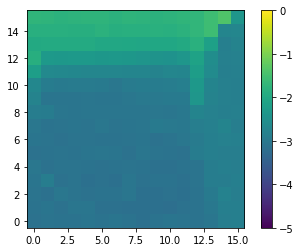

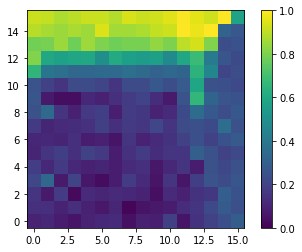

In [83]:
plt.imshow( numpy.log10( real_time_1e6/ 1024 ) , origin='lower', vmin=-5, vmax=0  )
plt.colorbar()
plt.show()


plt.imshow( numpy.log10( real_time_1e6/ time_taken_dengo ) , origin='lower', vmin=0, vmax=1  )
plt.colorbar()
plt.show()

In [13]:
error = get_name_from_file(name = 'error',filename = 'new/run_test.out')
error_list = []
for t in error:
    _time_ = t.strip("\n").split(':')[1]
    error_list.append( float(_time_) )

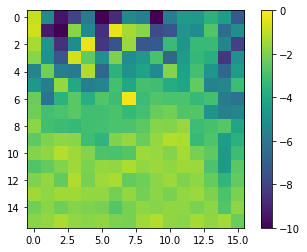

In [19]:
plt.imshow( numpy.log10( numpy.array(error_list).reshape((16,16)) ), vmin=-10,vmax = 0 )
plt.colorbar()

(array([245.,   5.,   1.,   2.,   0.,   0.,   0.,   2.,   0.,   1.]),
 array([4.12970790e-11, 6.15293725e-02, 1.23058745e-01, 1.84588117e-01,
        2.46117490e-01, 3.07646862e-01, 3.69176235e-01, 4.30705607e-01,
        4.92234979e-01, 5.53764352e-01, 6.15293724e-01]),
 <a list of 10 Patch objects>)

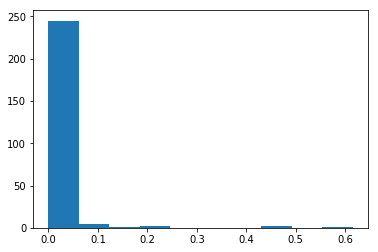

In [20]:
plt.hist(error_list)

In [56]:
0.01 / 5000

2e-06

In [7]:
time_taken_dengo[233]

NameError: name 'time_taken_dengo' is not defined

In [12]:
primordial.print_ccode(H2_1)

'd_H2_1[i] = k08[i]*H_1*H_m0 + k10[i]*H2_2*H_1 - k11[i]*H2_1*H_2 - k12[i]*H2_1*de - k13[i]*H2_1*H_1 + k19[i]*H2_2*H_m0 + k21[i]*H2_1*pow(H_1, 2) + k22[i]*pow(H_1, 3);'

In [11]:
H2_1 = list(primordial.required_species)[0]

In [14]:
type(primordial.species_total(H2_1))

sympy.core.add.Add

In [16]:
primordial.reactions.items()

[('k13', k13 : 1*H2_1 + 1*H_1 => 3*H_1),
 ('k01', k01 : 1*H_1 + 1*de => 1*H_2 + 2*de),
 ('k02', k02 : 1*H_2 + 1*de => 1*H_1),
 ('k03', k03 : 1*He_1 + 1*de => 1*He_2 + 2*de),
 ('k04', k04 : 1*He_2 + 1*de => 1*He_1),
 ('k05', k05 : 1*He_2 + 1*de => 1*He_3 + 2*de),
 ('k06', k06 : 1*He_3 + 1*de => 1*He_2),
 ('k07', k07 : 1*H_1 + 1*de => 1*H_m0),
 ('k08', k08 : 1*H_m0 + 1*H_1 => 1*H2_1 + 1*de),
 ('k09', k09 : 1*H_1 + 1*H_2 => 1*H2_2),
 ('k19', k19 : 1*H2_2 + 1*H_m0 => 1*H_1 + 1*H2_1),
 ('k14', k14 : 1*H_m0 + 1*de => 1*H_1 + 2*de),
 ('k11', k11 : 1*H2_1 + 1*H_2 => 1*H2_2 + 1*H_1),
 ('k18', k18 : 1*H2_2 + 1*de => 2*H_1),
 ('k15', k15 : 1*H_m0 + 1*H_1 => 2*H_1 + 1*de),
 ('k22', k22 : 2*H_1 + 1*H_1 => 1*H2_1 + 1*H_1),
 ('k10', k10 : 1*H2_2 + 1*H_1 => 1*H2_1 + 1*H_2),
 ('k21', k21 : 2*H_1 + 1*H2_1 => 2*H2_1),
 ('k17', k17 : 1*H_m0 + 1*H_2 => 1*H2_2 + 1*de),
 ('k12', k12 : 1*H2_1 + 1*de => 2*H_1 + 1*de),
 ('k16', k16 : 1*H_m0 + 1*H_2 => 2*H_1)]

In [39]:
rn, rxn = primordial.reactions.items()[-6]
a = rxn.species_equation('H_1')

In [34]:
rxn.species_equation??

In [37]:
rxn.lhs_equation??

In [40]:
import sympy

In [41]:
sympy.expand(a)

-2*k22[i]*H_1**3

In [44]:
a.replace(
... lambda x: x.is_Pow and x.exp > 0,
... lambda x: sympy.Mul(*[x.base]*x.exp, evaluate=False))

-2*k22[i]*H_1**3

In [49]:
def sack(expr):
    return expr.replace(
    lambda x: x.is_Pow and x.exp > 0,
    lambda x: sympy.Symbol('*'.join([x.base.name]*x.exp)))



In [52]:
b = a.replace(
    lambda x: x.is_Pow and x.exp > 0,
    lambda x: sympy.Symbol('*'.join([x.base.name]*x.exp)))

In [55]:
X = sympy.Symbol('x')

In [59]:
xxx = X*X*X + X*X + X**10

In [61]:
sack(xxx)

x*x + x*x*x + x*x*x*x*x*x*x*x*x*x

In [62]:
primordial.print_cooling??

In [6]:
(5.2 - 4.5) / 5.2

0.13461538461538464

In [8]:
primordial.print_cooling("").replace('[i]',"")

'= (-H2_1*gloverabel08_h2lte/(gloverabel08_h2lte/(H2_1*gloverabel08_gaH2 + H_1*gloverabel08_gaHI + H_2*gloverabel08_gaHp + He_1*gloverabel08_gaHe + de*gloverabel08_gael) + 1.0) - H_1*ceHI_ceHI*de - H_1*ciHI_ciHI*de - H_2*de*reHII_reHII - He_1*ciHeI_ciHeI*de - He_2*ceHeII_ceHeII*de - He_2*ceHeI_ceHeI*de*de - He_2*ciHeII_ciHeII*de - He_2*ciHeIS_ciHeIS*de*de - He_2*de*reHeII1_reHeII1 - He_2*de*reHeII2_reHeII2 - He_3*de*reHeIII_reHeIII - brem_brem*de*(H_2 + He_2 + 4.0*He_3) - compton_comp_*de*pow(z + 1.0, 4)*(T - 2.73*z - 2.73) + 0.5*1.0/(h2formation_ncrn/(H2_1*h2formation_ncrd2 + H_1*h2formation_ncrd1) + 1.0)*(-H2_1*H_1*h2formation_h2mcool + H_1*H_1*H_1*h2formation_h2mheat))*fmin(1.00000000000000, (1.0 - exp(-fmax(1.00000000000000e-5, mdensity)))/fmax(1.00000000000000e-5, mdensity));'

In [5]:
primordial.temperature_calculation(derivative_dge_dT=True)

'T*kb*(-H2_1*pow(_gammaH2_1_m1, 2)*dgammaH2_1_dT - H2_2*pow(_gammaH2_2_m1, 2)*dgammaH2_2_dT)/(density*mh) + kb*(H2_1*_gammaH2_1_m1 + H2_2*_gammaH2_2_m1 + H_1*_gamma_m1 + H_2*_gamma_m1 + H_m0*_gamma_m1 + He_1*_gamma_m1 + He_2*_gamma_m1 + He_3*_gamma_m1 + _gamma_m1*de)/(density*mh)'

In [6]:
primordial.temperature_calculation(get_dge=True)

'T*kb*(H2_1*_gammaH2_1_m1 + H2_2*_gammaH2_2_m1 + H_1*_gamma_m1 + H_2*_gamma_m1 + H_m0*_gamma_m1 + He_1*_gamma_m1 + He_2*_gamma_m1 + He_3*_gamma_m1 + _gamma_m1*de)/(density*mh) - ge'

In [7]:
from sympy import *

In [9]:
gamma = Symbol('gamma')

In [10]:
expr = 1 / (gamma - 1) + gamma 

In [11]:
y = Symbol('y')

In [12]:
expr.subs( {1/ (gamma - 1):y})

gamma + y

In [13]:
expr

gamma + 1/(gamma - 1)

In [15]:
type(printing.ccode(expr))

str

In [18]:
x = numpy.random.random(100).reshape((10,10))

In [19]:
x.transpose()

array([[0.33257191, 0.33919216, 0.93825709, 0.49875606, 0.32771598,
        0.37442842, 0.14104216, 0.33225958, 0.75451314, 0.18237815],
       [0.40563054, 0.0591847 , 0.56624357, 0.58263057, 0.6978978 ,
        0.14055508, 0.79351753, 0.47317642, 0.84724035, 0.24208293],
       [0.74658833, 0.80373491, 0.31834421, 0.86037844, 0.60896636,
        0.30539571, 0.60683157, 0.69979955, 0.21945444, 0.27002949],
       [0.48546201, 0.21626222, 0.77394794, 0.43417005, 0.04853463,
        0.59606964, 0.32026324, 0.0538502 , 0.49904593, 0.96686206],
       [0.82940282, 0.35605732, 0.22411216, 0.04933246, 0.64357479,
        0.79606815, 0.63843685, 0.12548904, 0.42721188, 0.71521974],
       [0.71279049, 0.56294713, 0.60932011, 0.85827116, 0.64460416,
        0.12379948, 0.36085704, 0.86435447, 0.49305024, 0.31618475],
       [0.21551685, 0.19869573, 0.78739702, 0.90320743, 0.58537816,
        0.5236393 , 0.61554155, 0.24410834, 0.26427174, 0.73083091],
       [0.18759607, 0.30981117, 0.9427867

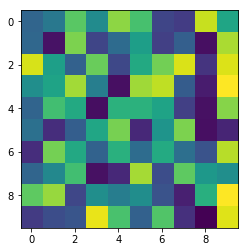

In [20]:
plt.imshow(x)

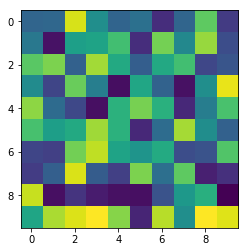

In [21]:
plt.imshow(x.transpose())

In [20]:
i = 0
for name, rate in sorted(primordial.cooling_actions.iteritems()):
    for name2 in sorted(rate.tables):
        print(name, name2)
        i += 1
print(i)

('brem', 'brem')
('ceHI', 'ceHI')
('ceHeI', 'ceHeI')
('ceHeII', 'ceHeII')
('ciHI', 'ciHI')
('ciHeI', 'ciHeI')
('ciHeII', 'ciHeII')
('ciHeIS', 'ciHeIS')
('cie_cooling', 'cieco')
('compton', 'comp_')
('gammah', 'gammah')
('gloverabel08', 'gaH2')
('gloverabel08', 'gaHI')
('gloverabel08', 'gaHe')
('gloverabel08', 'gaHp')
('gloverabel08', 'gael')
('gloverabel08', 'gphdl')
('gloverabel08', 'gpldl')
('gloverabel08', 'h2lte')
('h2formation', 'h2mcool')
('h2formation', 'h2mheat')
('h2formation', 'ncrd1')
('h2formation', 'ncrd2')
('h2formation', 'ncrn')
('reHII', 'reHII')
('reHeII1', 'reHeII1')
('reHeII2', 'reHeII2')
('reHeIII', 'reHeIII')
28


In [19]:
primordial.cooling_actions 

17

In [15]:
sorted(primordial.cooling_actions.values())

In [6]:
grackle_timeout = "/home/kwoksun2/grackle/src/example/grackle_runtime.out"
grackle_2d = numpy.loadtxt(grackle_timeout).reshape((16,16))

In [7]:
grackle_2d

array([[0.15625 , 0.15625 , 0.15625 , 0.15625 , 0.15625 , 0.15625 ,
        0.15625 , 0.15625 , 0.15625 , 0.15625 , 0.15625 , 0.15625 ,
        0.15625 , 0.15625 , 0.09375 , 0.09375 ],
       [0.140625, 0.15625 , 0.15625 , 0.171875, 0.171875, 0.171875,
        0.140625, 0.171875, 0.15625 , 0.140625, 0.15625 , 0.15625 ,
        0.140625, 0.15625 , 0.078125, 0.09375 ],
       [0.15625 , 0.15625 , 0.15625 , 0.15625 , 0.15625 , 0.140625,
        0.15625 , 0.15625 , 0.15625 , 0.15625 , 0.15625 , 0.15625 ,
        0.15625 , 0.15625 , 0.078125, 0.109375],
       [0.15625 , 0.15625 , 0.15625 , 0.140625, 0.15625 , 0.15625 ,
        0.15625 , 0.15625 , 0.15625 , 0.15625 , 0.15625 , 0.15625 ,
        0.171875, 0.15625 , 0.078125, 0.09375 ],
       [0.15625 , 0.15625 , 0.140625, 0.15625 , 0.15625 , 0.15625 ,
        0.15625 , 0.15625 , 0.171875, 0.15625 , 0.15625 , 0.15625 ,
        0.15625 , 0.15625 , 0.078125, 0.09375 ],
       [0.15625 , 0.15625 , 0.15625 , 0.140625, 0.15625 , 0.15625 ,
       

In [111]:
runtime_cvspils = !grep real testing_cache/cvspils_runtime.out

In [112]:
len(runtime_cvspils)

242

In [90]:
real_time = []
for t in runtime_cvspils:
    _time_ = t.strip("\n").split('\t')[1]
    real_time.append( change_time_to_s(_time_) )
    
real_time = numpy.array(real_time)

In [91]:
def change_time_to_s( min_s ):
    minutes, seconds =  min_s.strip('s').split('m')
    minute = float(minutes)
    second = float(seconds)
    
    total_time = minute*60.0 + second
    
    return total_time

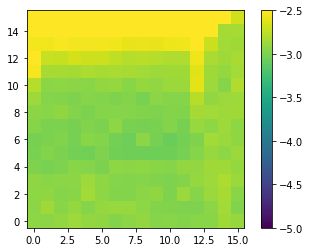

In [92]:
plt.imshow( numpy.log10( real_time.reshape((16,16)) / 1024), origin='lower', vmin=-5,vmax=-2.5 )
plt.colorbar()


In [107]:
numpy.log10( real_time / 1024)

array([-2.92039485, -2.9343882 , -2.90308999, -2.86138896, -2.90513053,
       -2.91061932, -2.96302509, -2.9351181 , -2.90173493, -2.95301431,
       -2.94211409, -2.96341477, -2.94063186, -2.94100194, -2.85770588,
       -2.89669081, -2.93075695, -2.85893011, -2.94026209, -2.89702526,
       -2.95645353, -2.90038409, -2.88710188, -2.88972603, -2.92251854,
       -2.96146987, -2.97527067, -2.98581429, -2.9817287 , -2.93841795,
       -2.8468404 , -2.97128263, -2.92394013, -2.91547958, -2.95760601,
       -2.9432291 , -2.84180247, -2.92679734, -2.96263576, -2.96654483,
       -2.93584924, -2.91165623, -2.98417544, -2.87612285, -2.95760601,
       -2.87294585, -2.82277924, -2.94434698, -2.9144335 , -2.94847065,
       -2.93075695, -2.93039549, -2.86979191, -2.92074807, -2.94922463,
       -2.9603071 , -2.95722151, -2.9756715 , -2.98663604, -2.96733088,
       -2.89735998, -2.86355194, -2.80862978, -2.87548559, -2.98745935,
       -3.002979  , -2.98132225, -2.94809415, -2.95301431, -2.99

In [108]:
real_time

array([1.23 , 1.191, 1.28 , 1.409, 1.274, 1.258, 1.115, 1.189, 1.284,
       1.141, 1.17 , 1.114, 1.174, 1.173, 1.421, 1.299, 1.201, 1.417,
       1.175, 1.298, 1.132, 1.288, 1.328, 1.32 , 1.224, 1.119, 1.084,
       1.058, 1.068, 1.18 , 1.457, 1.094, 1.22 , 1.244, 1.129, 1.167,
       1.474, 1.212, 1.116, 1.106, 1.187, 1.255, 1.062, 1.362, 1.129,
       1.372, 1.54 , 1.164, 1.247, 1.153, 1.201, 1.202, 1.382, 1.229,
       1.151, 1.122, 1.13 , 1.083, 1.056, 1.104, 1.297, 1.402, 1.591,
       1.364, 1.054, 1.017, 1.069, 1.154, 1.141, 1.033, 1.21 , 1.186,
       1.219, 1.166, 1.143, 1.267, 1.262, 1.425, 1.415, 1.317, 1.006,
       1.104, 1.049, 0.979, 0.955, 1.067, 0.952, 0.927, 0.927, 0.899,
       0.933, 0.985, 1.145, 1.345, 1.214, 1.374, 0.987, 1.038, 1.087,
       0.985, 1.168, 1.121, 0.963, 0.918, 1.192, 0.998, 0.891, 0.976,
       1.062, 1.453, 1.352, 1.242, 1.141, 1.037, 1.043, 1.   , 1.091,
       1.042, 1.225, 1.027, 0.991, 1.017, 1.108, 1.003, 1.319, 1.215,
       1.378, 1.222,

In [144]:
time_taken_dengo

array([[0.635, 0.654, 0.691, 0.724, 0.704, 0.63 , 0.681, 0.729, 0.593,
        0.677, 0.576, 0.76 , 0.584, 0.588, 0.806, 0.754],
       [0.608, 0.644, 0.624, 0.671, 0.757, 0.633, 0.592, 0.707, 0.635,
        0.606, 0.579, 0.587, 0.585, 0.619, 0.769, 0.828],
       [0.615, 0.645, 0.661, 0.792, 0.594, 0.638, 0.612, 0.717, 0.569,
        0.65 , 0.608, 0.591, 0.597, 0.782, 0.84 , 0.777],
       [0.55 , 0.628, 0.665, 0.544, 0.616, 0.714, 0.604, 0.629, 0.596,
        0.731, 0.584, 0.645, 0.554, 0.732, 0.811, 0.805],
       [0.66 , 0.61 , 0.585, 0.645, 0.649, 0.627, 0.69 , 0.657, 0.59 ,
        0.643, 0.58 , 0.577, 0.722, 0.774, 0.901, 0.81 ],
       [0.604, 0.581, 0.571, 0.587, 0.582, 0.65 , 0.742, 0.58 , 0.626,
        0.623, 0.589, 0.549, 0.633, 0.829, 0.885, 0.851],
       [0.69 , 0.657, 0.604, 0.63 , 0.728, 0.656, 0.716, 0.608, 0.726,
        0.603, 0.626, 0.618, 0.694, 0.92 , 0.887, 0.801],
       [0.668, 0.647, 0.654, 0.666, 0.624, 0.642, 0.633, 0.62 , 0.666,
        0.682, 0.763, 0.61

In [145]:
5000*1e-4

0.5